In [60]:
from bs4 import BeautifulSoup
import requests
import logging
import multiprocessing.dummy as mp
import os

Пишем функции для получения URL фильмов

In [61]:
def get_urls_from_afisha(base_url):
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    films = soup.findAll('li', {'class': 'lists__li'})
    return set(filter(None, map(lambda x: get_urls_function(x, 'name'), films)))


def get_urls_function(x, class_name):
    href_list = x.findAll('a', {'class': class_name})
    if len(href_list) != 0:
        current_url = href_list[0]['href']
        if current_url.find("https://afisha.tut.by/film") != -1:
            return href_list[0]['href']


def get_urls_from_online_cinema(base_url):
    return get_urls_from_online_cinema_page(base_url, set())


def get_urls_from_online_cinema_page(url, result_data):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    films = soup.findAll('li', {'class': 'lists__li'})
    urls = set(filter(None, map(lambda x: get_urls_function(x, 'media'), films)))
    result_data = result_data.union(urls)
    next_button = soup.find('li', {'class', 'p-next'}).find('a')
    if next_button is not None:
        next_url = next_button['href']
        return get_urls_from_online_cinema_page(next_url, result_data)
    else:
        return result_data


def get_urls_from_afisha_and_online_cinema(base_url_afisha, base_url_online_films):
    online = get_urls_from_online_cinema(base_url_online_films)
    afisha = get_urls_from_afisha(base_url_afisha)
    return afisha.union(online)


Получаем все ссылки на фильмы c афишы и онлайн кинотеатра

In [62]:


logging.basicConfig(level=logging.INFO)    
base_url_afisha = 'https://afisha.tut.by/film/'
base_url_online_cinema='https://afisha.tut.by/online-cinema/'
urlsOfFilms=get_urls_from_afisha_and_online_cinema(base_url_afisha,base_url_online_cinema)
logging.info("Number of films "+str(len(urlsOfFilms)))

INFO:root:Number of films 3315


Пишем функции для парсинга отдельных элементов страницы

In [63]:
def get_film_name(parsed_film_page):
    return parsed_film_page.findAll('h1', {'class': 'title'})[0].getText().rstrip()


def is_premiere(parsed_film_page):
    label = parsed_film_page.find('div', {'class': 'title__labels'}).findAll('span', {'class': 'label'})
    for val in label:
        if val.getText() == "Премьера":
            return True
    return False


def get_film_age_rank(parsed_film_page):
    label = parsed_film_page.find('div', {'class': 'title__labels'}).findAll('span', {'class': 'label'})
    for val in label:
        if val.getText().find("+") != -1:
            return val.getText()
    return "none"


def get_native_film_name(parsed_film_page):
    label = parsed_film_page.find('div', {'class': 'sub_title'})
    if label is not None:
        return label.getText()
    return "none"


def get_poster_url(parsed_film_page):
    return parsed_film_page.find('img', {'class': 'main_image'})["src"]


def get_genre(parsed_film_page):
    genres = parsed_film_page.findAll('a', {'itemprop': 'genre'})
    genres_dict = {}
    for genre in genres:
        genres_dict[genre.getText()] = {"name": genre.getText(), "url": genre["href"]}
    return genres_dict


def get_set_values(text):
    return set(text.split(", "))


def get_table_field_set(parsed_film_page, field_name):
    td = parsed_film_page.find('td', {'class': field_name})
    if td is not None:
        text = td.getText()
        return get_set_values(text)
    return set()


def get_table_field_single(parsed_film_page, field_name):
    td = parsed_film_page.find('td', {'class': field_name})
    if td is not None:
        return td.getText()
    return "none"


def get_table_field_single_with_url(parsed_film_page, field_name):
    td = parsed_film_page.find('td', {'class': field_name})
    if td is not None:
        a_tag = td.find('a')
        if a_tag is not None:
            return {"data": a_tag.getText(), "url": a_tag["href"]}
        return {"data": td.getText(), "url": "none"}
    return {"data": "none", "url": "none"}


def get_year_of_film(parsed_film_page):
    return get_table_field_single_with_url(parsed_film_page, 'year')


def get_duration(parsed_film_page):
    return get_table_field_single(parsed_film_page, 'duration')


def get_country(parsed_film_page):
    return set(map(lambda x: x.strip(),get_table_field_set(parsed_film_page, 'author')))


def get_showing_end_date(parsed_film_page):
    end_date = get_table_field_single(parsed_film_page, 'date')
    if end_date != "none":
        return end_date.split("В прокате до ")[1]
    return end_date


def get_afisha_rating(parsed_film_page):
    rating = parsed_film_page.find('span', {'class': 'rating-big__value'})
    if rating is not None:
        return rating.getText()
    return "none"


def get_not_afisha_rating(parsed_film_page, label):
    rating_tag = parsed_film_page.find('td', {'class': 'IMDb'})
    if rating_tag is not None:
        ratings = rating_tag.findAll("b")
        for rating in ratings:
            sibling = rating.findPreviousSibling('p')
            if sibling.getText() == label:
                return rating.getText()
    return "none"


def get_imdb_rating(parsed_film_page):
    return get_not_afisha_rating(parsed_film_page, 'Рейтинг IMDb')


def get_kinopoisk_rating(parsed_film_page):
    return get_not_afisha_rating(parsed_film_page, 'Кинопоиск')


def get_ratings(parsed_film_page):
    return {"afisha": get_afisha_rating(parsed_film_page), "imdb": get_imdb_rating(parsed_film_page),
            "kinopoisk": get_afisha_rating(parsed_film_page)}


def persons_from_string(p_tag, selector_text):
    persons = {}
    a_tags = p_tag.findAll('a')
    for a_tag in a_tags:
        name = a_tag.getText()
        persons[name] = {"name": name, "additional_information": a_tag['href']}
        a_tag.extract()
    names = filter(lambda x: x != "", p_tag.getText().split(selector_text + " ")[1].split(", "))
    for name in names:
        persons[name] = {"name": name, "additional_information": "none"}
    return persons


def get_director(parsed_film_page):
    previous_sibling = parsed_film_page.find('table', {'class': 'movie_info'})
    p_tag = previous_sibling.findNextSibling('p')
    if p_tag is not None:
        if p_tag.getText().find("Режиссер:") != -1:
            return persons_from_string(p_tag, "Режиссер:")
    return {}


def get_actors(parsed_film_page):
    previous_sibling = parsed_film_page.find('table', {'class': 'movie_info'})
    p_tags = previous_sibling.findNextSiblings('p', limit=2)
    for p_tag in p_tags:
        if p_tag is not None:
            if p_tag.getText().find("В ролях:") != -1:
                return persons_from_string(p_tag, "В ролях:")
    return {}


def get_description(parsed_film_page):
    description_div = parsed_film_page.find('div', {'itemprop': 'description'})
    if description_div is not None:
        siblings = description_div.findAll()
        for sibling in siblings:
            sibling.extract()
        return description_div.getText().replace("\n", "").replace("\t", "").strip()
    return "none"


def get_film_videos(parsed_film_page):
    media_div = parsed_film_page.find('div', {'id': 'event-photos'})
    if media_div is not None:
        result = set()
        video_frames = media_div.findAll('a', {'data-action': 'iframe'})
        for video_frame in video_frames:
            result.add(video_frame["href"])
        return result
    return set()


def get_film_images(parsed_film_page):
    media_div = parsed_film_page.find('div', {'id': 'event-photos'})
    if media_div is not None:
        result = set()
        video_frames = media_div.findAll('img')
        for video_frame in video_frames:
            result.add(video_frame["src"])
        return result
    return set()



Пишем функцию для парсинга страницы

In [64]:
def parse_film_page(url):
    logging.info(url)
    response_of_film_page = requests.get(url)
    parsed_film_page = BeautifulSoup(response_of_film_page.text, 'html.parser')
    name = get_film_name(parsed_film_page)
    data = {'url': url, 'name': name}  # set name and url of film
    data['is_premiere'] = is_premiere(parsed_film_page)  # is this film premiere
    data['age_rank'] = get_film_age_rank(parsed_film_page)  # age rank  (16+ and etc.)
    data['native_film_name'] = get_native_film_name(parsed_film_page)  # name of film in original
    data['poster_url'] = get_poster_url(parsed_film_page)  # url to film poster
    data['genres'] = get_genre(parsed_film_page)  # genres of film
    data['year'] = get_year_of_film(parsed_film_page)  # year of creation
    data['duration'] = get_duration(parsed_film_page)  # duration
    data['countries'] = get_country(parsed_film_page)  # countries 
    data['showing_end_date'] = get_showing_end_date(parsed_film_page)  # end date of showing in theaters
    data['desription'] = get_description(parsed_film_page)  # text description of film
    data['ratings'] = get_ratings(parsed_film_page)  # ratings
    data['directors'] = get_director(parsed_film_page)  # directors of film and link for additional director information
    data['actors'] = get_actors(parsed_film_page)  # actors  and link for additional actors information
    data['film_videos'] = get_film_videos(parsed_film_page)  # urls to videos of film (trailer and etc.)
    data['film_images'] = get_film_images(parsed_film_page)  # urls to images of film 
    return name, data


Пишем функцию для парсинга страниц

In [65]:
def parse_all_pages(urls):
    cores_num=os.cpu_count()
    logging.info("***************************START*****************************")
    p=mp.Pool(cores_num)
    parsed_pages=dict(p.map(parse_film_page,urls))
    logging.info("***************************END*****************************")
    return parsed_pages


Парсим страницы

In [66]:
data=parse_all_pages(urlsOfFilms)
logging.info("Prepared data for "+str(len(data))+" films")


INFO:root:***************************START*****************************
INFO:root:https://afisha.tut.by/film/volodya_bolshoy_volodya_malenkiy_47720/
INFO:root:https://afisha.tut.by/film/donskaya_povest_47429/
INFO:root:https://afisha.tut.by/film/poezdka_cherez_gorod_47986/
INFO:root:https://afisha.tut.by/film/gigant_67642/
INFO:root:https://afisha.tut.by/film/igry-v-soldatiki-74837/
INFO:root:https://afisha.tut.by/film/moy-papa-baryshnikov-83869/
INFO:root:https://afisha.tut.by/film/obman-88296/
INFO:root:https://afisha.tut.by/film/ke-dy-72363/
INFO:root:https://afisha.tut.by/film/s-veshchami-na-vylet/
INFO:root:https://afisha.tut.by/film/put_k_serdcu_48011/
INFO:root:https://afisha.tut.by/film/carevich_prosha_47528/
INFO:root:https://afisha.tut.by/film/begi_bez_oglyadki/
INFO:root:https://afisha.tut.by/film/umirat-ne-strashno-71357/
INFO:root:https://afisha.tut.by/film/smertnyy-prigovor-83632/
INFO:root:https://afisha.tut.by/film/listapad_v_moskve_molodost/
INFO:root:https://afisha.tu

Выполняем задание (от 05.10.2019)

Загружаем словарь в Spark DataFrame

In [67]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode


from pandas import DataFrame

In [68]:
spark = SparkSession.builder \
     .appName("load data") \
     .getOrCreate()

sc = spark.sparkContext

In [69]:


pdDF = DataFrame(data).transpose()
pdDF[['film_images','film_videos','countries']]=pdDF[['film_images','film_videos','countries']]\
    .applymap(list)

movies_df = spark.createDataFrame(pdDF)


Задание: Посчитайте сколько фильмов в каждой возрастной категории.


In [70]:
movies_by_age_rank_df=movies_df.groupBy("age_rank").count().orderBy("count",ascending=False)

movies_by_age_rank_df.show()

+--------+-----+
|age_rank|count|
+--------+-----+
|    none| 3032|
|     16+|  103|
|     18+|   68|
|     12+|   33|
|      6+|   16|
|     14+|    4|
|      0+|    3|
+--------+-----+



Задание: Посчитайте сколько фильмов по странам.



In [71]:
movie_count_df=movies_df.withColumn("country",explode(movies_df.countries))
movies_by_countries_df=movie_count_df.groupBy('country').count().orderBy("count",ascending=False)

movies_by_countries_df.show(1000)

+--------------------+-----+
|             country|count|
+--------------------+-----+
|                СССР| 1264|
|                 США|  609|
|              Россия|  602|
|             Франция|  257|
|      Великобритания|  163|
|            Германия|  110|
|             Украина|  110|
|              Италия|   83|
|              Канада|   78|
|             Испания|   62|
|             Бельгия|   45|
|           Австралия|   27|
|               Индия|   24|
|              Швеция|   18|
|           Швейцария|   17|
|            Беларусь|   15|
|               Китай|   15|
|              Польша|   14|
|              Япония|   12|
|          Узбекистан|   12|
|          Нидерланды|   12|
|               Дания|   11|
|             Мексика|   11|
|            Норвегия|   10|
|             Австрия|    9|
|          Люксембург|    9|
|               Чехия|    8|
|              Латвия|    8|
|            Болгария|    8|
|             Гонконг|    7|
|            Бразилия|    7|
|            И

Задание:
Посчитайте сколько фильмов по актерам

In [72]:
movies_by_actors_df=movies_df.select("name", explode(movies_df.actors).alias("actor_name", "data"))\
    .groupBy('actor_name').count().orderBy("count",ascending=False)

movies_by_actors_df.show(2000)

+--------------------+-----+
|          actor_name|count|
+--------------------+-----+
|  Борислав Брондуков|   46|
|Константин Степанков|   43|
|      Татьяна Шитова|   37|
|     Леонид Куравлёв|   35|
|     Николай Гринько|   34|
|       Георгий Вицин|   32|
|Александр Демьяненко|   31|
|           Лев Дуров|   31|
|       Ирина Киреева|   30|
|     Сергей Филиппов|   29|
|       Пётр Иващенко|   28|
|   Армен Джигарханян|   27|
|     Михаил Пуговкин|   26|
|  Александр Гаврилин|   25|
|     Павел Морозенко|   25|
|     Михаил Глузский|   25|
|       Иван Гаврилюк|   24|
|     Николай Крючков|   23|
|    Василий Дахненко|   23|
|       Юрий Саранцев|   23|
|      Евгений Леонов|   23|
|     Владимир Волков|   23|
|      Игорь Дмитриев|   22|
|    Сергей Никоненко|   22|
| Владимир Алексеенко|   22|
|    Татьяна Пельтцер|   22|
|     Иван Миколайчук|   22|
|        Лев Перфилов|   22|
|      Нина Русланова|   21|
|       Зиновий Гердт|   21|
|         Лесь Сердюк|   21|
|      Денис Б

Выполняем задание (от 19.10.2019)


Pie-chart рейтингов

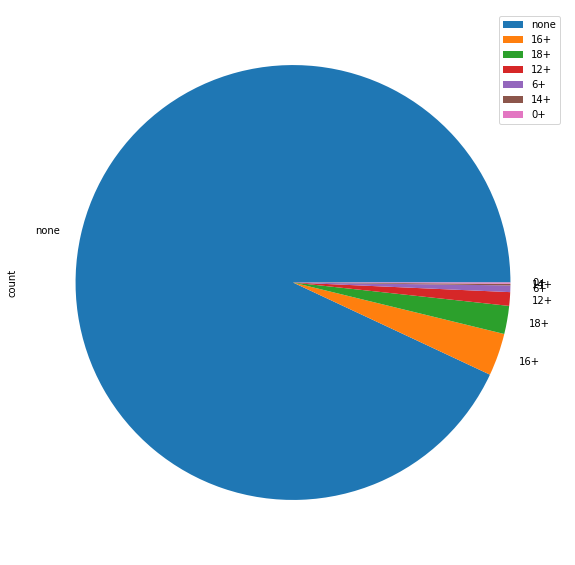

In [73]:
movies_by_age_rank_df.toPandas().set_index('age_rank').plot.pie(y="count", figsize=(10, 10))

Bar-chart стран

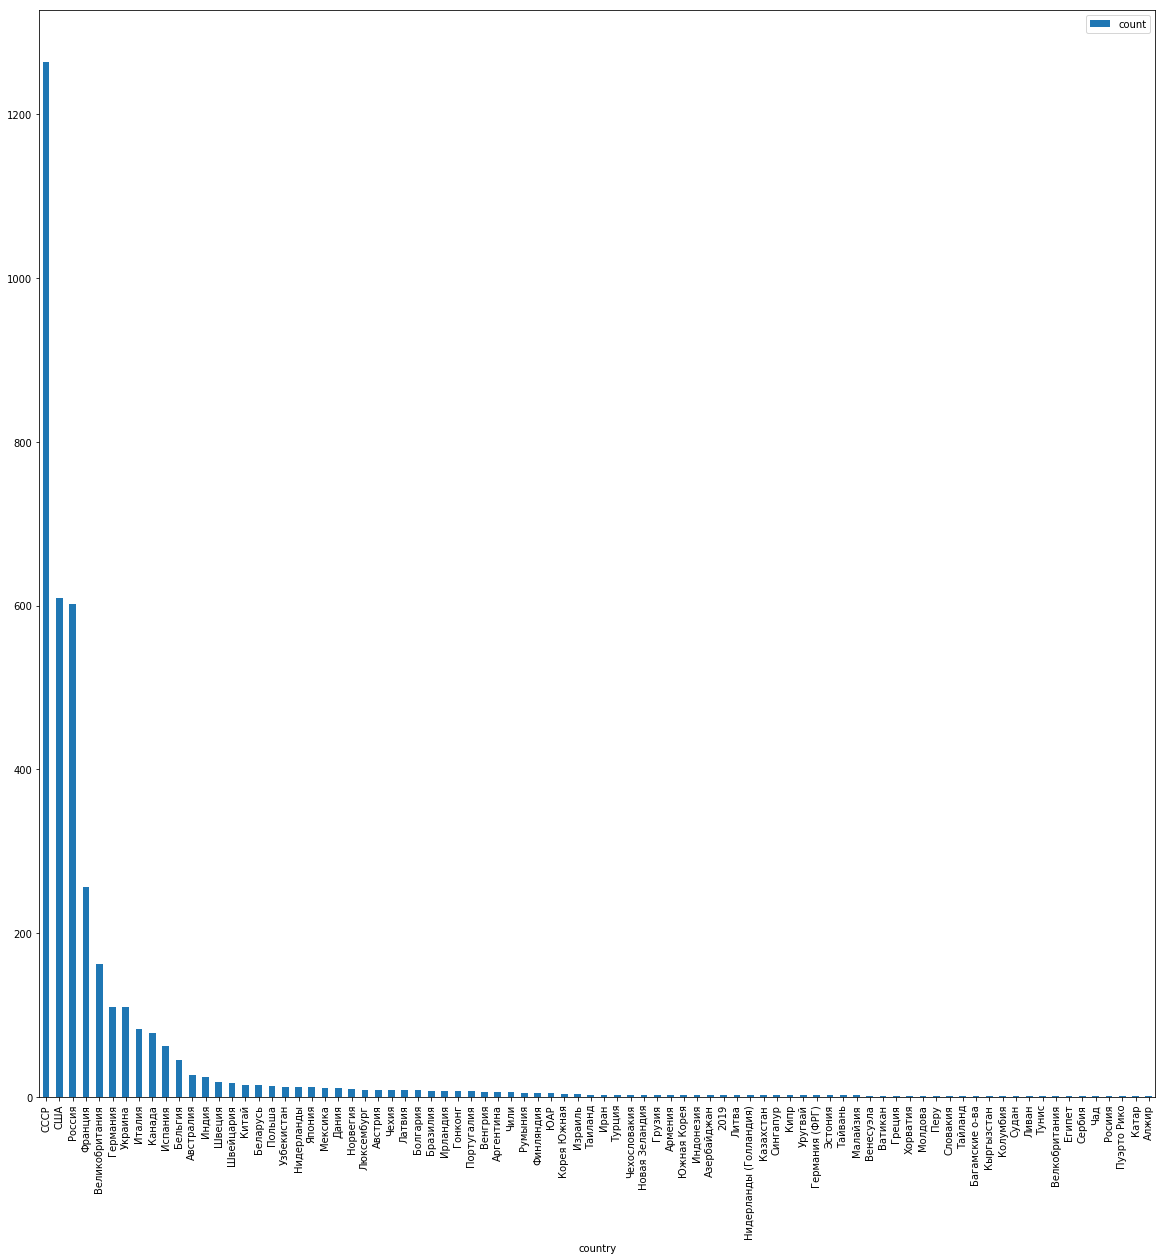

In [74]:
movies_by_countries_pd_df=movies_by_countries_df.toPandas()
movies_by_countries_pd_df.plot.bar(x="country",y="count", figsize=(20, 20))

"Облако слов" из актеров



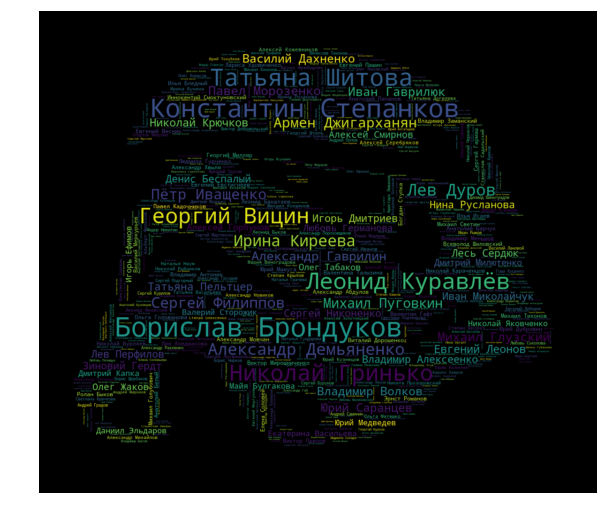

In [75]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

mask = np.array(Image.open("../img/film.png"))
movies_by_actors_pd_df=movies_by_actors_df.toPandas()
movies_by_actors_dict = dict(zip(movies_by_actors_pd_df['actor_name'].tolist(), movies_by_actors_pd_df['count'].tolist()))
wc = WordCloud(width=1024, height=768, max_words=3000,mask=mask).generate_from_frequencies(movies_by_actors_dict)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


"Облако слов" из стран

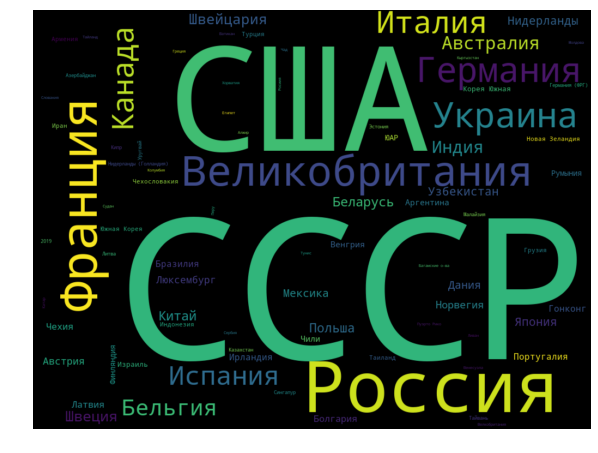

In [76]:
movies_by_countries_dict = dict(zip(movies_by_countries_pd_df['country'].tolist(), movies_by_countries_pd_df['count'].tolist()))
wc = WordCloud(width=1024, height=768, max_words=200).generate_from_frequencies(movies_by_countries_dict)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()